# [British Airways Job Simulation](https://www.theforage.com/simulations/british-airways/data-science-yqoz)
## Predictive modeling of customer bookings
This project provided a dataset containing customers' information regarding their flight booking experience. The critical information of the dataset is whether the customer actually completed the booking. A predictive model will be built after exploratory data analysis to estimate if a customer would go ahead with the booking based on the given features.

### Exploratory data analysis

In [1]:
import importlib
import britishairways_modules
importlib.reload(britishairways_modules)

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10') # mpl.style.available
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

random_state = 4
np.random.seed(random_state)

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
print(df.shape)
df.head()

(50000, 14)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [6]:
df['booking_complete'].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [7]:
df['booking_complete'].value_counts(normalize=True)

booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64

The classes in the target variable is imbalanced. Downsampling on label `0` will be used to balance number of both classes.

## Withhold Validation Set

In [8]:
df_down = pd.concat([
    df.loc[df['booking_complete'] == 0].sample(n=df.loc[df['booking_complete'] == 1].shape[0], random_state=random_state),
    df.loc[df['booking_complete'] == 1]
]).reset_index(drop=True)

df_down.shape

(14956, 14)

In [9]:
val = df_down.sample(frac=0.2, random_state=random_state)
train = df_down.drop(index=val.index)
val.shape, train.shape

((2991, 14), (11965, 14))

In [10]:
train['booking_complete'].value_counts()

booking_complete
1    6001
0    5964
Name: count, dtype: int64

In [11]:
val['booking_complete'].value_counts()

booking_complete
0    1514
1    1477
Name: count, dtype: int64

## Continue EDA

In [12]:
num_cols = train.select_dtypes(include='number').columns.tolist()
cat_cols = train.select_dtypes(exclude='number').columns.tolist()

### Categorical Features

In [13]:
cat_cols

['sales_channel', 'trip_type', 'route', 'booking_origin']

#### `route`

In [14]:
train.drop(columns=['route'], inplace=True)
val.drop(columns=['route'], inplace=True)

#### `booking_origin`

In [15]:
train.drop(columns=['booking_origin'], inplace=True)
val.drop(columns=['booking_origin'], inplace=True)

### Numeric Features

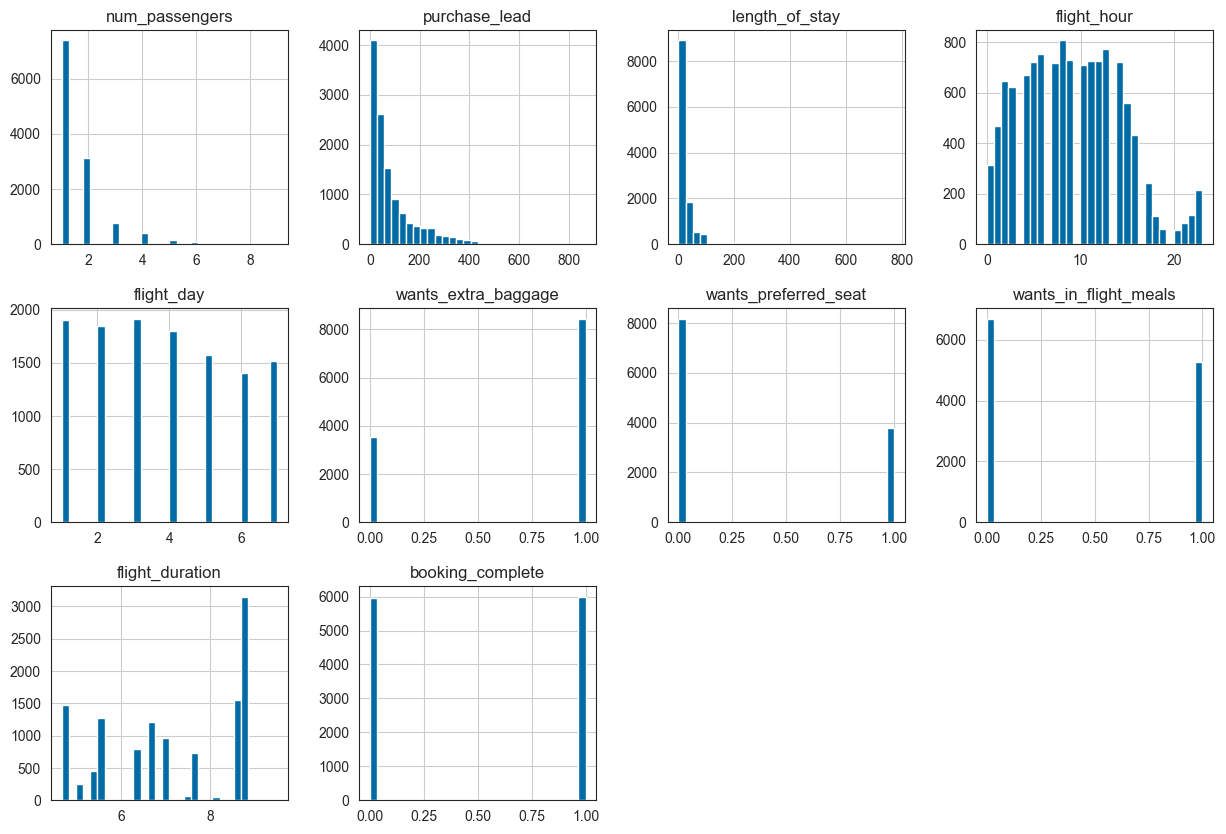

In [16]:
train[num_cols].hist(bins=30, figsize=(15, 10), layout=(3, 4))
plt.show()

In [17]:
def visualise_sum(df, feature, target='booking_complete', bins=10, **kwargs):
    sns.histplot(data=df, x=feature, hue=target, multiple='fill', bins=bins, **kwargs)
    plt.title(f"Distribution of {target} by {feature}")
    plt.show()

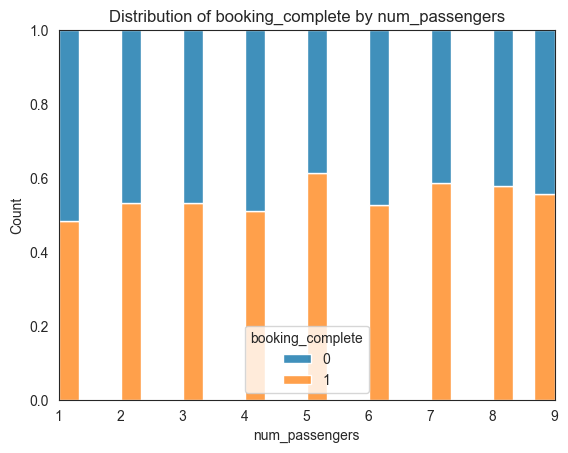

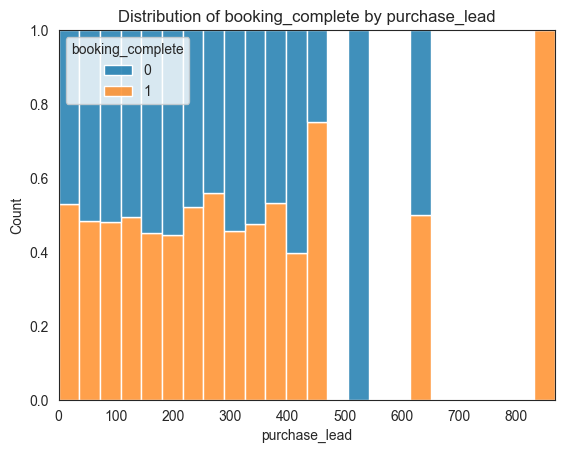

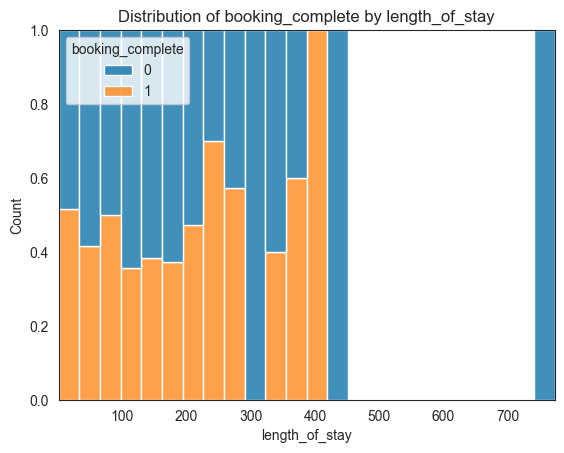

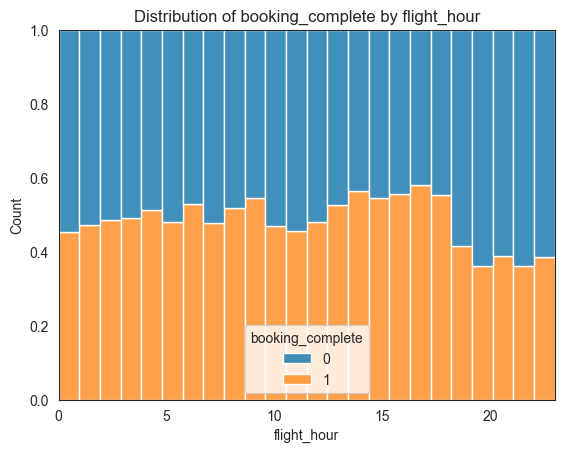

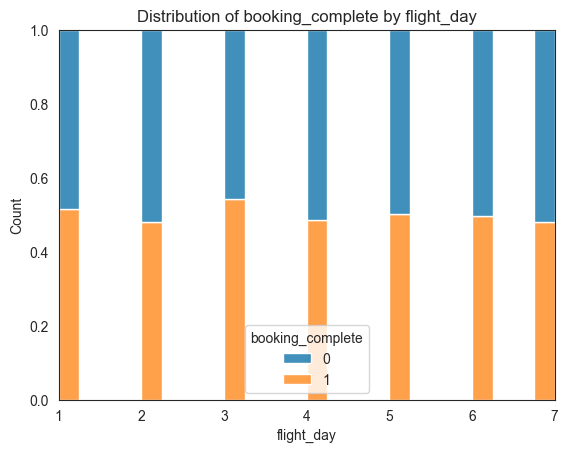

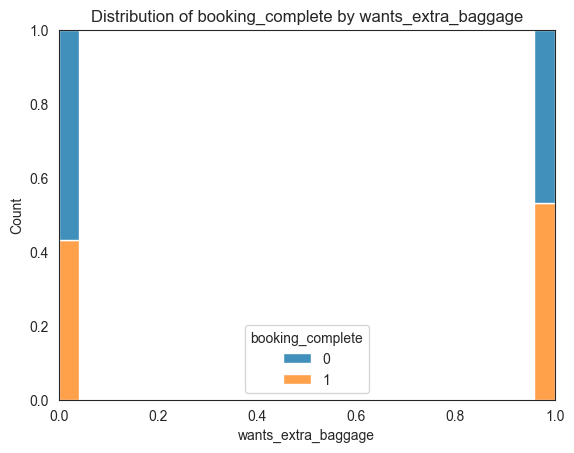

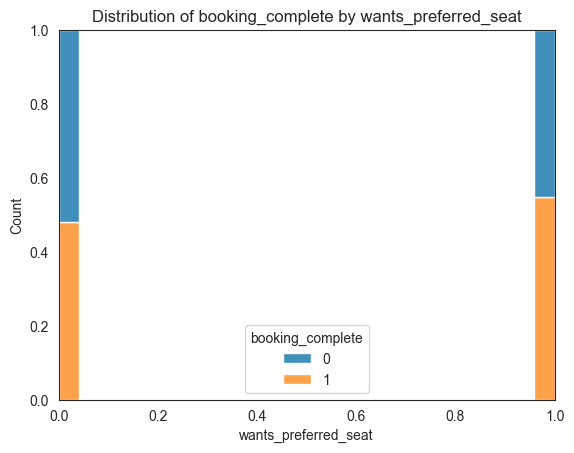

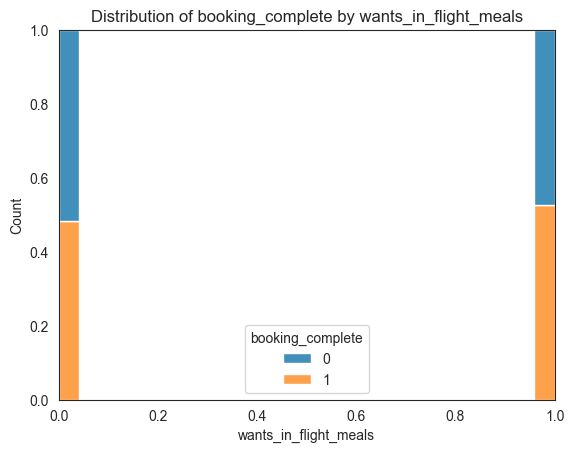

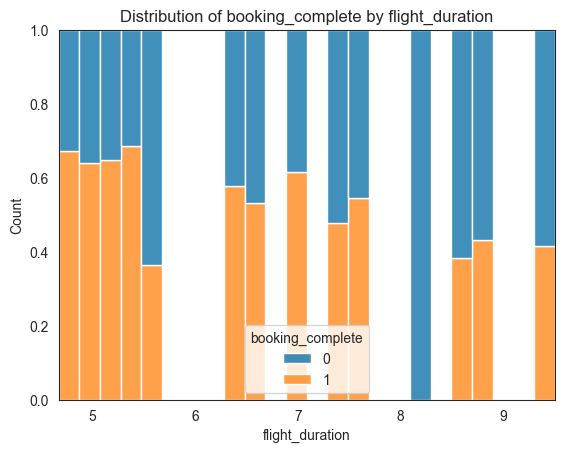

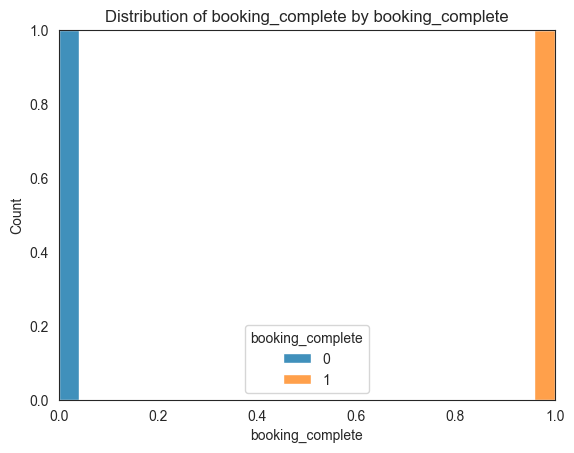

In [18]:
for col in num_cols:
    visualise_sum(train, col, target='booking_complete', bins=24)

# Data Preprocessing

In [19]:
X_train, y_train = train.drop(columns=['booking_complete']), train['booking_complete']
X_val, y_val = val.drop(columns=['booking_complete']), val['booking_complete']

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [21]:
num_cols = train.select_dtypes(include='number').drop(columns=['num_passengers', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'booking_complete']).columns.tolist()
cat_cols = train.select_dtypes(exclude='number').columns.tolist()

In [22]:
num_cols

['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

In [23]:
cat_cols

['sales_channel', 'trip_type']

In [24]:
pipe_preprocess = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('cat_extra', OrdinalEncoder(), ['wants_extra_baggage', 'wants_preferred_seat', 'num_passengers', 'wants_in_flight_meals', 'flight_day'])
        ]
    ))
])

pipe_preprocess.fit(X_train)

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
X_train = pipe_preprocess.transform(X_train)
X_val = pipe_preprocess.transform(X_val)

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score

In [27]:
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Recall Score:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.6278836509528586
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.63      1514
           1       0.62      0.62      0.62      1477

    accuracy                           0.63      2991
   macro avg       0.63      0.63      0.63      2991
weighted avg       0.63      0.63      0.63      2991

Recall Score: 0.6201760324983073
F1 Score: 0.6220713073005093
Confusion Matrix:
 [[962 552]
 [561 916]]


In [28]:
gb = GradientBoostingClassifier(random_state=random_state)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Recall Score:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.641925777331996
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65      1514
           1       0.64      0.62      0.63      1477

    accuracy                           0.64      2991
   macro avg       0.64      0.64      0.64      2991
weighted avg       0.64      0.64      0.64      2991

Recall Score: 0.6154366960054164
F1 Score: 0.6292834890965732
Confusion Matrix:
 [[1011  503]
 [ 568  909]]


In [29]:
pd.DataFrame({'feature': pipe_preprocess.get_feature_names_out(), 'importance': gb.feature_importances_}).sort_values(by='importance', ascending=False)


,feature,importance
3,num__flight_duration,0.351533
1,num__length_of_stay,0.296720
9,cat_extra__wants_extra_baggage,0.115531
0,num__purchase_lead,0.071514
2,num__flight_hour,0.037721
10,cat_extra__wants_preferred_seat,0.032300
4,cat__sales_channel_Internet,0.026534
5,cat__sales_channel_Mobile,0.022723
12,cat_extra__wants_in_flight_meals,0.018961
8,cat__trip_type_RoundTrip,0.010103


In [30]:
import sklearn
import optuna
from sklearn.metrics import f1_score

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['GradientBoosting', 'RandomForest'])
    if classifier_name == 'GradientBoosting':
         gb_loss = trial.suggest_categorical('gb_loss', ['log_loss', 'exponential'])
         gb_learning_rate = trial.suggest_float('gb_learning_rate', .001, 1, log=True)
         gb_n_estimators = trial.suggest_int('gb_n_estimators', 50, 500, step=50)
         gb_subsample = trial.suggest_float('gb_subsample', .1, 1, step=.1)
         gb_criterion = trial.suggest_categorical('gb_criterion', ['friedman_mse', 'squared_error'])
         gb_max_depth = trial.suggest_int('gb_max_depth', 2, 32, log=True)
         classifier_obj = sklearn.ensemble.GradientBoostingClassifier(
             loss=gb_loss, 
             learning_rate=gb_learning_rate, 
             n_estimators=gb_n_estimators, 
             subsample=gb_subsample, 
             criterion=gb_criterion, 
             max_depth=gb_max_depth,
             random_state=random_state,
             validation_fraction=0.1,
             n_iter_no_change=10
             )
    else:
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 100, step=10)
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, 
            n_estimators=rf_n_estimators,
            random_state=random_state
            )

    classifier_obj.fit(X_train, y_train)
    # accuracy = classifier_obj.score(X_val, y_val)
    f1 = f1_score(y_val, classifier_obj.predict(X_val))
    return f1

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

/Users/moswai/Documents/Mos_DataScience/venv/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-03 23:56:44,635] A new study created in memory with name: no-name-ab59eab3-2e9d-448d-88a6-c7bdef5484bc
[I 2025-08-03 23:56:44,778] Trial 0 finished with value: 0.6243567753001715 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 60, 'rf_max_depth': 2}. Best is trial 0 with value: 0.6243567753001715.
[I 2025-08-03 23:57:01,712] Trial 1 finished with value: 0.6165162153126045 and parameters: {'classifier': 'GradientBoosting', 'gb_loss': 'log_loss', 'gb_learning_rate': 0.00144395372200026, 'gb_n_estimators': 150, 'gb_subsample': 0.6, 'gb_criterion': 'squared_error', 'gb_max_depth': 22}. Best is trial 0 with value: 0.6243567753001715.
[I 2025-08-03 23:57:01,768] Trial 2 finished wit

In [31]:
study.best_params

{'classifier': 'GradientBoosting',
 'gb_loss': 'log_loss',
 'gb_learning_rate': 0.012711746730787144,
 'gb_n_estimators': 200,
 'gb_subsample': 0.5,
 'gb_criterion': 'friedman_mse',
 'gb_max_depth': 8}

In [32]:
if study.best_params['classifier'] == 'GradientBoosting':
    gb_optuna = GradientBoostingClassifier(
        loss=study.best_params['gb_loss'],
        learning_rate=study.best_params['gb_learning_rate'],
        n_estimators=study.best_params['gb_n_estimators'],
        subsample=study.best_params['gb_subsample'],
        criterion=study.best_params['gb_criterion'],
        max_depth=study.best_params['gb_max_depth'],
        random_state=random_state,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    gb_optuna.fit(X_train, y_train)
    y_pred = gb_optuna.predict(X_val)
else:
    rf_optuna = RandomForestClassifier(
        max_depth=study.best_params['rf_max_depth'],
        n_estimators=study.best_params['rf_n_estimators'],
        random_state=random_state
    )
    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Recall Score:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.6532932129722501
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.65      0.66      1514
           1       0.65      0.66      0.65      1477

    accuracy                           0.65      2991
   macro avg       0.65      0.65      0.65      2991
weighted avg       0.65      0.65      0.65      2991

Recall Score: 0.6553825321597834
F1 Score: 0.6511940800538177
Confusion Matrix:
 [[986 528]
 [509 968]]


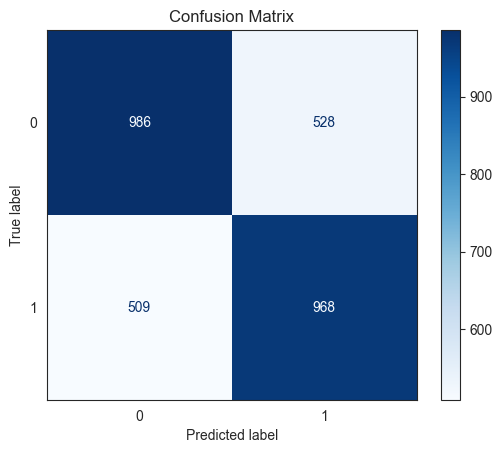

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [34]:
if study.best_params['classifier'] == 'GradientBoosting':
    gb_importance = pd.DataFrame({'feature': pipe_preprocess.get_feature_names_out(), 'importance': gb_optuna.feature_importances_}).sort_values(by='importance', ascending=False)[:10]
else:
    rf_importance = pd.DataFrame({'feature': pipe_preprocess.get_feature_names_out(), 'importance': rf_optuna.feature_importances_}).sort_values(by='importance', ascending=False)[:10]

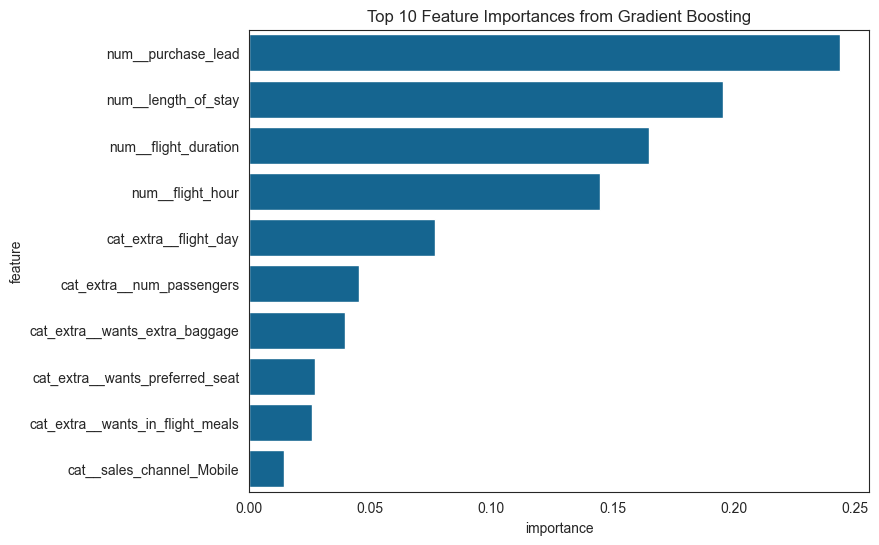

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
if study.best_params['classifier'] == 'GradientBoosting':
    sns.barplot(gb_importance, x='importance', y='feature', ax=ax)
    plt.title("Top 10 Feature Importances from Gradient Boosting")
else:
    sns.barplot(rf_importance, x='importance', y='feature', ax=ax)
    plt.title("Top 10 Feature Importances from Random Forest")
plt.show()